# Local Interpretable Model-agnostic Explanations (LIME) - Homework 3 - Karol Pustelnik

In this homework we will focus on another method for explaining black-box models - `LIME`. We will use the same dataset as in the previous homework, the famous heart disease dataset. We will use the same models as in the previous homework: the Xgboost and Logistic regression. 

The following topics will be covered:

1) Calculation of LIME explanation for a given observation using packages lime and dalex.
   
2) Comparison of LIME for diffrent observations in the dataset.
   
3) Comparison of LIME and SHAP for the same observation.
   
4) In detail comparisation of LIME between Xgboost and Logistic regression models, to see if there are any systematic differences between the explanations.



# Theoretical background - LIME
LIME stands for Local Interpretable Model-agnostic Explanations.

1) Model agnosticism refers to the property of LIME using which it can give explanations for any given supervised learning model by treating as a `black-box` separately. This means that LIME `can handle almost any model.`
   
2) Local explanations mean that LIME gives explanations that are locally faithful within the surroundings or vicinity of the observation/sample being explained.

# Importing packages

In [108]:
import dalex as dx
import xgboost
import lime
import sklearn
import pandas as pd
import numpy as np
import warnings
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
import plotly.io as pio
pio.renderers.default = "notebook"
import matplotlib.pyplot as plt


# Loading code from previous homeworks




In [ ]:
# Import data
data = pd.read_csv('heart.csv')
data_org = pd.read_csv('heart.csv')

# One hot encoding of categorical features

data = pd.get_dummies(data, columns = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'])

# Splitting the data

y = data['output'] # Target variable
X = data.drop(['output'], axis=1) # Features

# Xgboost
model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss"
)

model.fit(X, y)

# Logistic regression
log_reg = LogisticRegression() 
log_reg.fit(X, y) # Fitting model




# XGBoost Model prediction & explanation on chosen patients
I will use Xgboost model to predict the heart disease of two selected patients.

`The first patient`, number 56, is a Male, aged 48 years, with chest pain type 0 (typical angina), resting blood pressure of 122 mm Hg, cholestoral of 222 mg/dl, fasting blood sugar of 0 (false), resting electrocardiographic results of 0 (normal), maximum heart rate achieved of 186, exercise induced angina of 0 (no), ST depression induced by exercise relative to rest of 0.0, the slope of the peak exercise ST segment of 2, number of major vessels of 0, and thalassemia of 2 (reversi). 

The model predicts that the patient has a `~0.99 probability of NOT having a heart disease`. The model's `prediction is correct`, as the patient `does not have a heart disease`.


In [ ]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]
explainer = dx.Explainer(model, X, y, predict_function=pf_xgboost_classifier_default, label="GBM")

In [160]:
patient56 = X[56:57]
print(f'Probability of no Heart disease: {model.predict_proba(patient56)[0][1]}')

Probability of no Heart disease: 0.9939232468605042


In [112]:
explanation = explainer.predict_surrogate(patient56, random_state = 41)

## Interpretation of effect values for patient 56

According to the LIME explanation, the most important features that led to a prediction of `no heart disease` for patient 56 are:

1) caa_0 = 1 - number of major vessels of 0 - effect ~ 0.39 - it had positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has 1 major vessels.

2) cp_0 = 1 - chest pain type 0 (typical angina) - effect ~ -0.23 - it had negative effect on the prediction, meaning that the patient has a higher probability of having a heart disease if he has chest pain type 1 (atypical angina).

3) sex_0 = 0 - not being female (being male) - effect ~ -0.185 - it had negative effect on the prediction, meaning that the patient has a higher probability of having a heart disease if he is male.

4) thall_2 = 1 - thallium stress result of 2 (reversi) - effect ~ 0.18 - it had positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has thalassemia of 2 (reversi).

5) slp_1 = 0 - slope of the peak exercise ST segment not being 0 (upsloping) - effect ~ 0.12 - it had a positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has slope of the peak exercise ST segment not equal to 0 (non-upsloping).

etc.

In [113]:
explanation.result

,variable,effect
0,0.00 < caa_0 <= 1.00,0.396056
1,0.00 < cp_0 <= 1.00,-0.236079
2,sex_0 <= 0.00,-0.185147
3,0.00 < thall_2 <= 1.00,0.179805
4,slp_1 <= 0.00,0.124392
5,47.50 < age <= 55.00,0.078624
6,211.00 < chol <= 240.00,0.073421
7,thall_3 <= 0.00,0.066644
8,oldpeak <= 0.00,0.063945
9,0.00 < exng_0 <= 1.00,0.054786


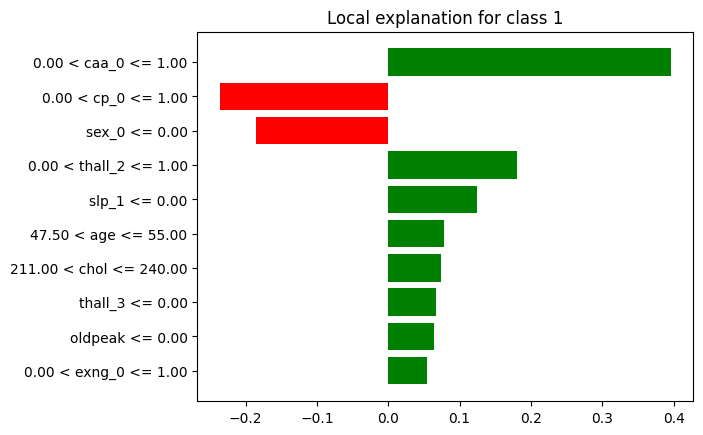

In [114]:
explanation.plot()

## Local prediction for patient 56

The local prediction for patient 56 is `~0.855 probability of NOT having a heart disease`. The local prediction is very close to the model's prediction, which is `~0.99 probability of NOT having a heart disease`. The model's `local prediction is correct`, as the patient does not have a heart disease.

## How is the local prediction calculated?

To calculate the local prediction based on the LIME explanation, we need to multiply the effect values of the features that are present in the explanation by the values of these features for the given patient. Then we need to sum all the products. The result is the local prediction for the given patient.

As all the features present in the explanation are binary, we can simply sum the effect values of the features that are present in the explanation and add the interecept. The result is the local prediction for the given patient.

`explanation.result['effect'].sum() + explanation.intercept[1]` = `0.8557108502130372`

In [115]:
explanation.result['effect'].sum() + explanation.intercept[1]

0.8557108502130372

`The second patient`, number 167, is a Female aged 62 years, with chest pain type 0 (typical angina), resting blood pressure of 140 mm Hg, cholestoral of 268 mg/dl, fasting blood sugar of 0 (false), resting electrocardiographic results of 0 (normal), maximum heart rate achieved of 160, exercise induced angina of 0 (no), ST depression induced by exercise relative to rest of 3, the slope of the peak exercise ST segment of 0, number of major vessels of 2, and thalassemia of 2 (normal).

The model predicts that the patient has a `~0.019 probability of not having heart disease`. The model's `prediction is correct`, as the patient actually `does have a heart disease`.

## Interpretation of effect values for patient 167

According to LIME explanation, the most important features that led to a prediction of `heart disease` for patient 167 are:

1) `caa_0 == 0` - number of major vessels is not equal to 0, `effect ~ -0.39` - it had negative attribution to the prediction, meaning that the patient has higher probability of having heart disease if his number of major vessels is not equal to 0

2) `cp_0 = 1` - chest pain of type 0 (typical angina), `effect ~ -0.24` - it had negative attribution to the prediction, meaning that the patient has higher probability of having a heart disease if type of his chest pain is `typical angina`.

3) `oldpeak > 1.60` - ST depression induced by exercise relative to rest, `effect ~ -0.19` - it had negative attribution to the prediction, meaning that the patient has higher probability of having a heart disease if his oldpeak measure is higher than 1.60.

4) `sex_0 = 1` - being female, effect ~ 0.18, it has a positive attribution to the prediction, meaning that the patient has a lower probability of heart disease if he is female.

etc.

In [161]:
patient167 = X[167:168]
print(f'Probability of no Heart disease: {model.predict_proba(patient167)[0][1]}')

Probability of no Heart disease: 0.0199551060795784


In [117]:
explanation = explainer.predict_surrogate(patient167, random_state = 41)

In [118]:
explanation.result

,variable,effect
0,caa_0 <= 0.00,-0.395290
1,0.00 < cp_0 <= 1.00,-0.235935
2,oldpeak > 1.60,-0.187958
3,0.00 < sex_0 <= 1.00,0.184051
4,0.00 < thall_2 <= 1.00,0.180459
5,slp_1 <= 0.00,0.126095
6,thall_3 <= 0.00,0.070932
7,240.00 < chol <= 274.50,-0.063508
8,0.00 < exng_0 <= 1.00,0.055369
9,restecg_1 <= 0.00,-0.039833


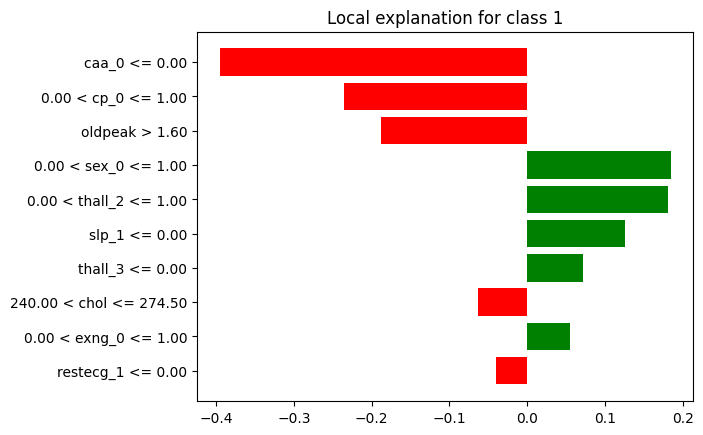

In [119]:
explanation.plot()

# Comparison of LIME for diffrent observations in the dataset - XGBoost model

Let us now compare the LIME explanations for 100 randomly chosen patients. We will use the XGBoost model to predict the heart disease of these patients. We will calculate basic statistics for the effect values. We will also plot the distribution of effect values for selected features. This way will be able to see if there are any systematic differences between the explanations.

In [120]:
sample = X.sample(100, random_state=41)

In [121]:
df_list = []
for i in range(len(sample)):
    patient = sample.iloc[i]
    explanation = explainer.predict_surrogate(patient, random_state = 41)
    result = explanation.result
    df_list.append(result)

In [122]:
features = []
for result in df_list:
    for feature in result['variable']:
        if feature not in features:
            features.append(feature)
        

In [123]:
features_df = {key: [] for key in features} # Create a dictionary with empty lists for each feature

In [124]:
for result in df_list:
    for i in range(len(result)):
        feature_name = result['variable'][i]
        feature_value = result['effect'][i]
        features_df[feature_name].append(feature_value)

In [125]:
features_df_xgb = pd.DataFrame.from_dict(features_df, orient='index').T # Convert dictionary to dataframe

# Table & interpretation

If we look closely on the row conatining standard deviation of each feature, we can see that the values are very close to zero. It means that the attributions of each features do not vary across many patients. 

Let's look closely at feature '0.00 < caa_0 <= 1.00 (caa_0 == 1)`. 

62 patient out of 100 sampled had 0 major vessels. If we look at boxplot of the effect values of this feature, we can see that:

1) the minimum contribution value was 0.386 while maximum was 0.398, a small diffrence between these values suggest that this feature has similiar contribution to a model prediction for many patients.

2) small value of standard deviation also suggest the above thesis.


In [126]:
features_df_xgb.describe()

,0.00 < caa_0 <= 1.00,0.00 < cp_0 <= 1.00,oldpeak > 1.60,sex_0 <= 0.00,thall_2 <= 0.00,slp_1 <= 0.00,chol <= 211.00,thall_3 <= 0.00,exng_0 <= 0.00,133.50 < thalachh <= 153.00,...,0.00 < oldpeak <= 0.80,55.00 < age <= 61.00,0.00 < restecg_1 <= 1.00,0.00 < sex_0 <= 1.00,47.50 < age <= 55.00,0.00 < thall_2 <= 1.00,restecg_1 <= 0.00,211.00 < chol <= 240.00,thalachh > 166.00,trtbps > 140.00
count,62.000000,53.000000,33.000000,63.000000,44.000000,51.000000,31.000000,63.000000,25.000000,17.000000,...,15.000000,25.000000,4.000000,37.000000,22.000000,56.000000,4.000000,23.000000,12.000000,2.000000
mean,0.392215,-0.235544,-0.193381,-0.184407,-0.178553,0.128361,0.110001,0.064781,-0.055813,0.043358,...,0.173184,-0.108203,0.037547,0.184936,0.081027,0.177451,-0.038127,0.076791,0.053074,-0.037402
std,0.003177,0.002934,0.002734,0.001906,0.002077,0.002544,0.002620,0.002694,0.002269,0.001242,...,0.001439,0.002780,0.002839,0.002081,0.002217,0.001819,0.002669,0.002652,0.002282,0.002934
min,0.385958,-0.241471,-0.199318,-0.187698,-0.183808,0.122388,0.104345,0.059831,-0.062822,0.041146,...,0.171068,-0.113588,0.035251,0.179778,0.076931,0.172961,-0.041030,0.071984,0.049715,-0.039476
25%,0.389944,-0.237331,-0.195505,-0.185479,-0.180023,0.126639,0.108352,0.062783,-0.057018,0.042579,...,0.172326,-0.110511,0.035387,0.184108,0.079851,0.176221,-0.039435,0.075672,0.051270,-0.038439
50%,0.392309,-0.236363,-0.193171,-0.184900,-0.178649,0.128408,0.109773,0.064505,-0.056038,0.043248,...,0.173366,-0.107325,0.036826,0.184864,0.081231,0.177367,-0.038430,0.076862,0.052828,-0.037402
75%,0.394828,-0.233931,-0.190813,-0.182967,-0.177141,0.129945,0.111894,0.066763,-0.054522,0.044467,...,0.173842,-0.105707,0.038987,0.186543,0.082366,0.178739,-0.037122,0.078608,0.054384,-0.036365
max,0.398481,-0.225877,-0.188966,-0.179879,-0.174629,0.134766,0.114359,0.071534,-0.051554,0.045040,...,0.175510,-0.104538,0.041286,0.188424,0.084855,0.181065,-0.034617,0.081151,0.056931,-0.035327


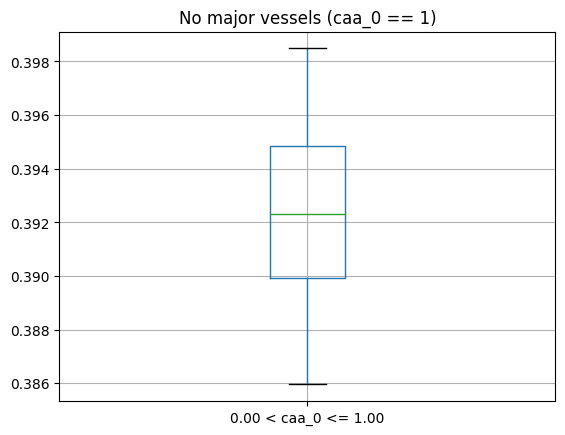

In [165]:
features_df_xgb.boxplot(column = ['0.00 < caa_0 <= 1.00' ])
plt.title('No major vessels (caa_0 == 1)');

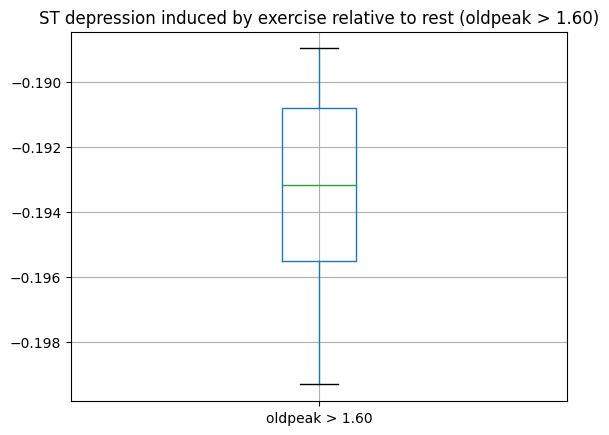

In [166]:
features_df_xgb.boxplot(['oldpeak > 1.60'])
plt.title('ST depression induced by exercise relative to rest (oldpeak > 1.60)');

## Stability of explanations

We will now run the LIME explanation for the same patient 100 times and see how stable the explanations are. We will calculate the mean and standard deviation of the effect values for each feature. We will also plot the distribution of effect values for each feature. This way will be able to see if there are any systematic differences between the explanations.

In [168]:
patient = X[123:124]
df_list = []
for i in range(100):
    explanation = explainer.predict_surrogate(patient)
    result = explanation.result
    df_list.append(result)

In [169]:
features = []
for result in df_list:
    for feature in result['variable']:
        if feature not in features:
            features.append(feature)

In [170]:
features_df = {key: [] for key in features} # Create a dictionary with empty lists for each feature

In [171]:
for result in df_list:
    for i in range(len(result)):
        feature_name = result['variable'][i]
        feature_value = result['effect'][i]
        features_df[feature_name].append(feature_value)

In [172]:
features_df = pd.DataFrame.from_dict(features_df, orient='index').T # Convert dictionary to dataframe

# Interpretation of table & plots

The results from table say, that standard deviation of features is very small (close to 0), meaning that there is little variability in terms of effect values, when running the algorithm for diffrent seeds.

We can conclude that the method is stable, and not susceptible to initialization.

In [173]:
features_df.describe()

,0.00 < caa_0 <= 1.00,cp_0 <= 0.00,0.00 < thall_2 <= 1.00,0.00 < sex_0 <= 1.00,slp_1 <= 0.00,thall_3 <= 0.00,47.50 < age <= 55.00,240.00 < chol <= 274.50,oldpeak <= 0.00,trtbps <= 120.00,0.00 < exng_0 <= 1.00,thalachh > 166.00,restecg_2 <= 0.00,thall_0 <= 0.00,restecg_1 <= 0.00,cp_3 <= 0.00,caa_4 <= 0.00,0.00 < cp_2 <= 1.00
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,78.000000,75.000000,16.000000,65.000000,15.000000,18.000000,19.000000,5.000000,4.000000,4.000000,1.000000
mean,0.390727,0.234271,0.183675,0.186149,0.125615,0.076339,0.085801,-0.064261,0.064909,0.056750,0.062470,0.061374,0.007335,-0.016289,-0.054234,-0.059147,-0.030527,0.055181
std,0.007718,0.008306,0.008112,0.008595,0.007400,0.007923,0.009237,0.007582,0.007037,0.006748,0.006782,0.006400,0.067858,0.090573,0.003602,0.004649,0.069953,NaN
min,0.372182,0.210315,0.166393,0.162480,0.110474,0.059795,0.059168,-0.084346,0.051056,0.044269,0.050722,0.052982,-0.083797,-0.139085,-0.057052,-0.064034,-0.074826,0.055181
25%,0.384712,0.228822,0.177772,0.179495,0.119436,0.069849,0.079313,-0.069582,0.059991,0.054463,0.057477,0.056134,-0.061521,-0.090514,-0.056019,-0.062550,-0.064597,0.055181
50%,0.391817,0.234717,0.182497,0.186292,0.125253,0.076793,0.085034,-0.063562,0.064657,0.055956,0.062370,0.060593,0.044406,-0.056201,-0.055346,-0.059166,-0.060599,0.055181
75%,0.395237,0.240485,0.188189,0.192343,0.130226,0.081128,0.092435,-0.058950,0.070064,0.058770,0.066982,0.066947,0.064938,0.072970,-0.054782,-0.055764,-0.026530,0.055181
max,0.410133,0.253063,0.206351,0.210100,0.144478,0.096722,0.107335,-0.044896,0.078998,0.068542,0.076606,0.071378,0.090554,0.123166,-0.047971,-0.054221,0.073916,0.055181


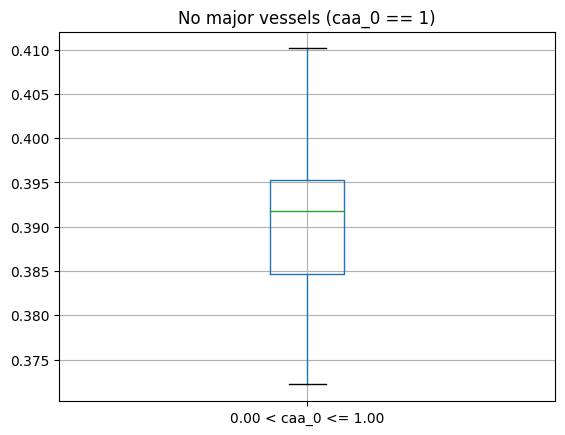

In [174]:
features_df.boxplot(['0.00 < caa_0 <= 1.00'])
plt.title('No major vessels (caa_0 == 1)');

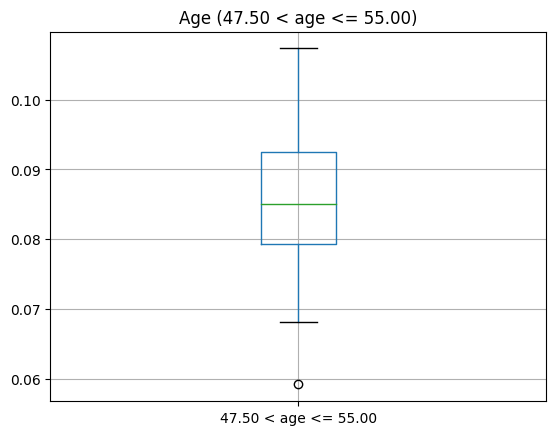

In [175]:
features_df.boxplot(['47.50 < age <= 55.00'])
plt.title('Age (47.50 < age <= 55.00)');

# Comparison of SHAP and LIME explanations 

Let us now compare explanation derived from SHAP and LIME for the same patient. We will decide whether these methods produce substantially diffrent results.

It is worth noting however, that the methods explain models in diffrent ways. SHAP is a global method, while LIME is a local method. 

SHAP takes into account all the features in the dataset, while LIME takes into account only a subset of features that are present in the explanation.

SHAP also takes into account the interactions between features, while LIME does not.

These differences in the methods make it difficult to compare the results.

## For patient 56

LIME Explanation:

The most important features that led to a prediction of `no heart disease` for patient 56 are:

1) `caa_0 == 1` - number of major vessels of 1 - effect ~ 0.39 - it had positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has 1 major vessel.

2) `cp_0 == 1` - chest pain of type 1 (atypical angina) - effect ~ -0.24 - it had negative effect on the prediction, meaning that the patient has a higher probability of having a heart disease if type of his chest pain is `atypical angina`.

These were two most important features in the LIME explanation.

SHAP Explanation:

1) `caa_0 == 1` - number of major vessels of 1 - increased average response by ~ 0.241 - it had positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has 1 major vessel.

2) `thall_2 = 1` - thallium stress result of 2 (reversi) - increased average response by ~ 0.101 - it had positive effect on the prediction, meaning that the patient has a higher probability of not having a heart disease if he has thallium stress result of 2.

## Conclusion

For both of these methods, the most important features were `caa_0 == 1`. However, the rest of the features were diffrent. For SHAP, the second most important feature was `thall_2 = 1`, while for LIME it was `cp_0 == 1`. Meaning that, according to SHAP, thallium stress result of 2 was more meaninfgul information to conclude whether patient has a heart disease than information about chest pain of atypical angina. For LIME however, the opposite was true.



In [176]:
explanation = explainer.predict_surrogate(patient56, random_state = 41)

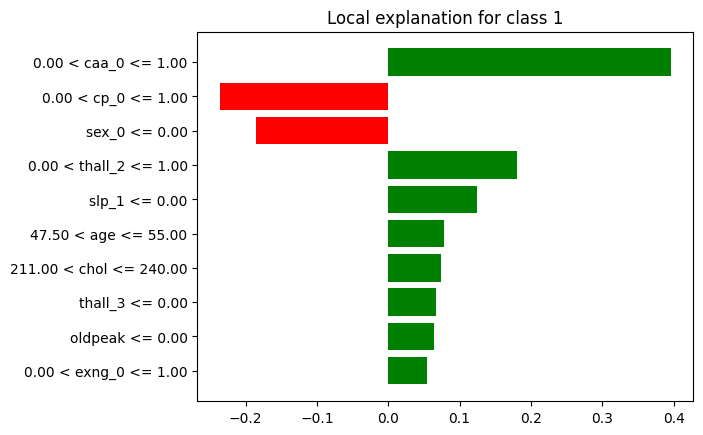

In [177]:
explanation.plot()

In [178]:
shap_attributions = explainer.predict_parts(patient56, type="shap", random_state = 43)
shap_attributions.plot()

# Stability of SHAP

To see if SHAP is stable, we will run the SHAP explanation for the same patient 100 times and see how stable the explanations are. We will calculate the mean and standard deviation of the effect values for each feature. We will also plot the distribution of effect values for each feature. This way will be able to see if there are any systematic differences between the explanations.

In [179]:
variable = shap_attributions.result['variable']
contribution = shap_attributions.result['contribution']
shap_df = pd.DataFrame({'variable': variable, 'contribution' : contribution})
table_st = pd.pivot_table(shap_df, values='variable',
            columns=['variable'], aggfunc=np.mean)

In [180]:
features = table_st.columns

In [181]:
features_df = {key: [] for key in features} # Create a dictionary with empty lists for each feature

In [182]:
df_list = []
for i in range(10):
    shap_attributions = explainer.predict_parts(patient56, type="shap")
    variable = shap_attributions.result['variable']
    contribution = shap_attributions.result['contribution']
    shap_df = pd.DataFrame({'variable': variable, 'contribution' : contribution})
    df_list.append(shap_df)

    

In [183]:
for result in df_list:
    for i in range(len(result)):
        feature_name = result['variable'].iloc[i]
        feature_value = result['contribution'].iloc[i]
        features_df[feature_name].append(feature_value)

In [184]:
features_df = pd.DataFrame(features_df)

## Interpretation of the results

The standard deviation for some feature is very high (age = 48, caa_0 = 1) meaning that the effect values for these features vary a lot. This is not a good sign, as it means that the method is not stable. However, recall that SHAP takes into account interactions between features. This means that the effect values for some features will vary a lot, as they are dependent on other features.

`Age of 48` feature, according to the results below, can be both positively and negatively attributed to the prediction.

`chol == 222` feature, according to the results below, can be both positively and negatively attributed to the prediction.


In [185]:
features_df.describe()

,age = 48.0,caa_0 = 1.0,caa_1 = 0.0,caa_2 = 0.0,caa_3 = 0.0,caa_4 = 0.0,chol = 222.0,cp_0 = 1.0,cp_1 = 0.0,cp_2 = 0.0,...,sex_1 = 1.0,slp_0 = 0.0,slp_1 = 0.0,slp_2 = 1.0,thalachh = 186.0,thall_0 = 0.0,thall_1 = 0.0,thall_2 = 1.0,thall_3 = 0.0,trtbps = 122.0
count,260.000000,260.000000,260.000000,260.000000,260.0,260.0,260.000000,260.000000,260.000000,260.000000,...,260.0,260.0,260.000000,260.000000,260.000000,260.0,260.000000,260.000000,260.000000,260.000000
mean,-0.001784,0.245775,0.000566,0.001863,0.0,0.0,0.065432,-0.048858,0.000116,-0.002899,...,0.0,0.0,0.016692,0.011292,0.019429,0.0,-0.000211,0.085970,0.043673,-0.004695
std,0.043420,0.108666,0.003144,0.001236,0.0,0.0,0.048301,0.036198,0.000223,0.003335,...,0.0,0.0,0.012730,0.010493,0.026428,0.0,0.000462,0.060063,0.035262,0.007578
min,-0.163367,0.068498,-0.006811,0.000218,0.0,0.0,-0.021650,-0.133299,-0.000208,-0.014081,...,0.0,0.0,0.000104,-0.009907,-0.061662,0.0,-0.002430,0.006099,0.007186,-0.030287
25%,-0.022628,0.149462,-0.001056,0.000763,0.0,0.0,0.033429,-0.079532,0.000000,-0.004886,...,0.0,0.0,0.004569,0.004044,0.005974,0.0,-0.000189,0.047923,0.022129,-0.008587
50%,0.002039,0.245237,0.000328,0.001770,0.0,0.0,0.055261,-0.054584,0.000000,-0.001840,...,0.0,0.0,0.015758,0.008891,0.011032,0.0,0.000000,0.067444,0.032288,-0.004091
75%,0.020397,0.343367,0.001798,0.002574,0.0,0.0,0.089454,-0.009533,0.000223,-0.000296,...,0.0,0.0,0.027389,0.015953,0.028903,0.0,0.000000,0.098990,0.052266,0.001769
max,0.119485,0.409856,0.015408,0.005628,0.0,0.0,0.246430,0.000387,0.001285,0.003666,...,0.0,0.0,0.045641,0.053037,0.116121,0.0,0.000000,0.287002,0.211860,0.011709


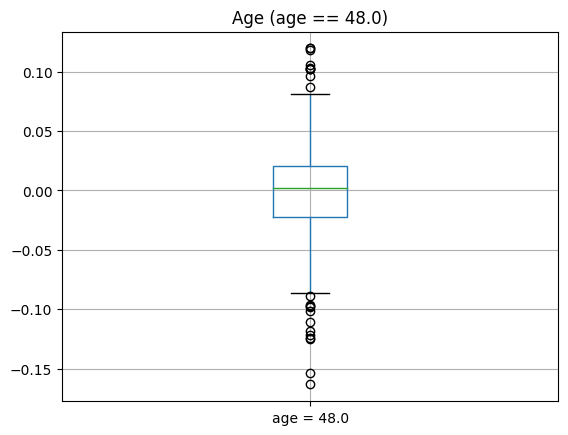

In [186]:
features_df.boxplot(column = 'age = 48.0')
plt.title('Age (age == 48.0)');

# Comparison of LIME for two diffrent models: Logistic Regression and GBM

We will now compare the LIME explanations for 100 randomly chosen patients. We will use the Logistic Regression and GBM models to predict the heart disease of these patients. We will calculate basic statistics for the effect values. We will also plot the distribution of effect values for selected features. This way will be able to see if there are any systematic differences between the explanations.

In [ ]:
# Comparison of LIME for two diffrent models: Logistic Regression and GBM

explainer_log = dx.Explainer(log_reg, X, y, predict_function=pf_xgboost_classifier_default, label="Log reg")

In [188]:
sample = X.sample(100, random_state=41)


In [189]:
df_list = []
for i in range(len(sample)):
    patient = sample.iloc[i]
    explanation = explainer.predict_surrogate(patient, random_state = 41)
    result = explanation.result
    df_list.append(result)

In [190]:
features = []
for result in df_list:
    for feature in result['variable']:
        if feature not in features:
            features.append(feature)

In [191]:
features_df_log = {key: [] for key in features} # Create a dictionary with empty lists for each feature

In [192]:
for result in df_list:
    for i in range(len(result)):
        feature_name = result['variable'][i]
        feature_value = result['effect'][i]
        features_df_log[feature_name].append(feature_value)

In [193]:
features_df_log = pd.DataFrame.from_dict(features_df_log, orient='index').T # Convert dictionary to dataframe

## Interpretation of the results

The LIME explanation for both of the models are very similar. The most important features are the same, and the effect values are very similar. This is a good sign, as it means that the method is stable.



In [194]:
print('Results for Logistic Regression:')

Results for Logistic Regression:


In [195]:
features_df_log.describe()

,0.00 < caa_0 <= 1.00,0.00 < cp_0 <= 1.00,oldpeak > 1.60,sex_0 <= 0.00,thall_2 <= 0.00,slp_1 <= 0.00,chol <= 211.00,thall_3 <= 0.00,exng_0 <= 0.00,133.50 < thalachh <= 153.00,...,0.00 < oldpeak <= 0.80,55.00 < age <= 61.00,0.00 < restecg_1 <= 1.00,0.00 < sex_0 <= 1.00,47.50 < age <= 55.00,0.00 < thall_2 <= 1.00,restecg_1 <= 0.00,211.00 < chol <= 240.00,thalachh > 166.00,trtbps > 140.00
count,62.000000,53.000000,33.000000,63.000000,44.000000,51.000000,31.000000,63.000000,25.000000,17.000000,...,15.000000,25.000000,4.000000,37.000000,22.000000,56.000000,4.000000,23.000000,12.000000,2.000000
mean,0.392215,-0.235544,-0.193381,-0.184407,-0.178553,0.128361,0.110001,0.064781,-0.055813,0.043358,...,0.173184,-0.108203,0.037547,0.184936,0.081027,0.177451,-0.038127,0.076791,0.053074,-0.037402
std,0.003177,0.002934,0.002734,0.001906,0.002077,0.002544,0.002620,0.002694,0.002269,0.001242,...,0.001439,0.002780,0.002839,0.002081,0.002217,0.001819,0.002669,0.002652,0.002282,0.002934
min,0.385958,-0.241471,-0.199318,-0.187698,-0.183808,0.122388,0.104345,0.059831,-0.062822,0.041146,...,0.171068,-0.113588,0.035251,0.179778,0.076931,0.172961,-0.041030,0.071984,0.049715,-0.039476
25%,0.389944,-0.237331,-0.195505,-0.185479,-0.180023,0.126639,0.108352,0.062783,-0.057018,0.042579,...,0.172326,-0.110511,0.035387,0.184108,0.079851,0.176221,-0.039435,0.075672,0.051270,-0.038439
50%,0.392309,-0.236363,-0.193171,-0.184900,-0.178649,0.128408,0.109773,0.064505,-0.056038,0.043248,...,0.173366,-0.107325,0.036826,0.184864,0.081231,0.177367,-0.038430,0.076862,0.052828,-0.037402
75%,0.394828,-0.233931,-0.190813,-0.182967,-0.177141,0.129945,0.111894,0.066763,-0.054522,0.044467,...,0.173842,-0.105707,0.038987,0.186543,0.082366,0.178739,-0.037122,0.078608,0.054384,-0.036365
max,0.398481,-0.225877,-0.188966,-0.179879,-0.174629,0.134766,0.114359,0.071534,-0.051554,0.045040,...,0.175510,-0.104538,0.041286,0.188424,0.084855,0.181065,-0.034617,0.081151,0.056931,-0.035327


In [196]:
print('Results for XGBoost:')

Results for XGBoost:


In [197]:
features_df_xgb.describe()

,0.00 < caa_0 <= 1.00,0.00 < cp_0 <= 1.00,oldpeak > 1.60,sex_0 <= 0.00,thall_2 <= 0.00,slp_1 <= 0.00,chol <= 211.00,thall_3 <= 0.00,exng_0 <= 0.00,133.50 < thalachh <= 153.00,...,0.00 < oldpeak <= 0.80,55.00 < age <= 61.00,0.00 < restecg_1 <= 1.00,0.00 < sex_0 <= 1.00,47.50 < age <= 55.00,0.00 < thall_2 <= 1.00,restecg_1 <= 0.00,211.00 < chol <= 240.00,thalachh > 166.00,trtbps > 140.00
count,62.000000,53.000000,33.000000,63.000000,44.000000,51.000000,31.000000,63.000000,25.000000,17.000000,...,15.000000,25.000000,4.000000,37.000000,22.000000,56.000000,4.000000,23.000000,12.000000,2.000000
mean,0.392215,-0.235544,-0.193381,-0.184407,-0.178553,0.128361,0.110001,0.064781,-0.055813,0.043358,...,0.173184,-0.108203,0.037547,0.184936,0.081027,0.177451,-0.038127,0.076791,0.053074,-0.037402
std,0.003177,0.002934,0.002734,0.001906,0.002077,0.002544,0.002620,0.002694,0.002269,0.001242,...,0.001439,0.002780,0.002839,0.002081,0.002217,0.001819,0.002669,0.002652,0.002282,0.002934
min,0.385958,-0.241471,-0.199318,-0.187698,-0.183808,0.122388,0.104345,0.059831,-0.062822,0.041146,...,0.171068,-0.113588,0.035251,0.179778,0.076931,0.172961,-0.041030,0.071984,0.049715,-0.039476
25%,0.389944,-0.237331,-0.195505,-0.185479,-0.180023,0.126639,0.108352,0.062783,-0.057018,0.042579,...,0.172326,-0.110511,0.035387,0.184108,0.079851,0.176221,-0.039435,0.075672,0.051270,-0.038439
50%,0.392309,-0.236363,-0.193171,-0.184900,-0.178649,0.128408,0.109773,0.064505,-0.056038,0.043248,...,0.173366,-0.107325,0.036826,0.184864,0.081231,0.177367,-0.038430,0.076862,0.052828,-0.037402
75%,0.394828,-0.233931,-0.190813,-0.182967,-0.177141,0.129945,0.111894,0.066763,-0.054522,0.044467,...,0.173842,-0.105707,0.038987,0.186543,0.082366,0.178739,-0.037122,0.078608,0.054384,-0.036365
max,0.398481,-0.225877,-0.188966,-0.179879,-0.174629,0.134766,0.114359,0.071534,-0.051554,0.045040,...,0.175510,-0.104538,0.041286,0.188424,0.084855,0.181065,-0.034617,0.081151,0.056931,-0.035327


# Summary

In this notebook, we investigated in detail the LIME method. We were able to see how the method works, and how it can be used to explain the predictions of a model. We gave explanation of how the local prediction of LIME method is calculated. Furthermore, we checked the stability of the LIME method in terms of 

1) the stability of the explanations for the same patient

2) the stability of the explanations for the same model

3) the stability of the explanations for the same feature across many patients

We concluded that the LIME method is stable in terms of 1), 2) and 3).

We also compared the LIME method with SHAP, and we were able to see that the results are similiar only for the most important feature, the effect values for the rest of the features varied a lot. This is not a good sign, as it means that the method is not stable. However, we gave an explanation to that: SHAP takes into account interactions between features. This means that the effect values for some features will vary a lot, as they are dependent on other features. 